# 正解データ分析

    

# 1. ライブラリ導入

In [13]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
import json
import glob
import matplotlib.pyplot as plt
from matplotlib import animation, rc, gridspec
from IPython.display import HTML
import numpy as np
from math import *
import os
from collections import defaultdict
import time
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = ['Hiragino Sans']
from matplotlib.animation import FuncAnimation



## 1. 調布市　阪上さん加工の正解データ（06_fin.json）　
### 1-1. 各時間帯におけるPoIの滞在分布

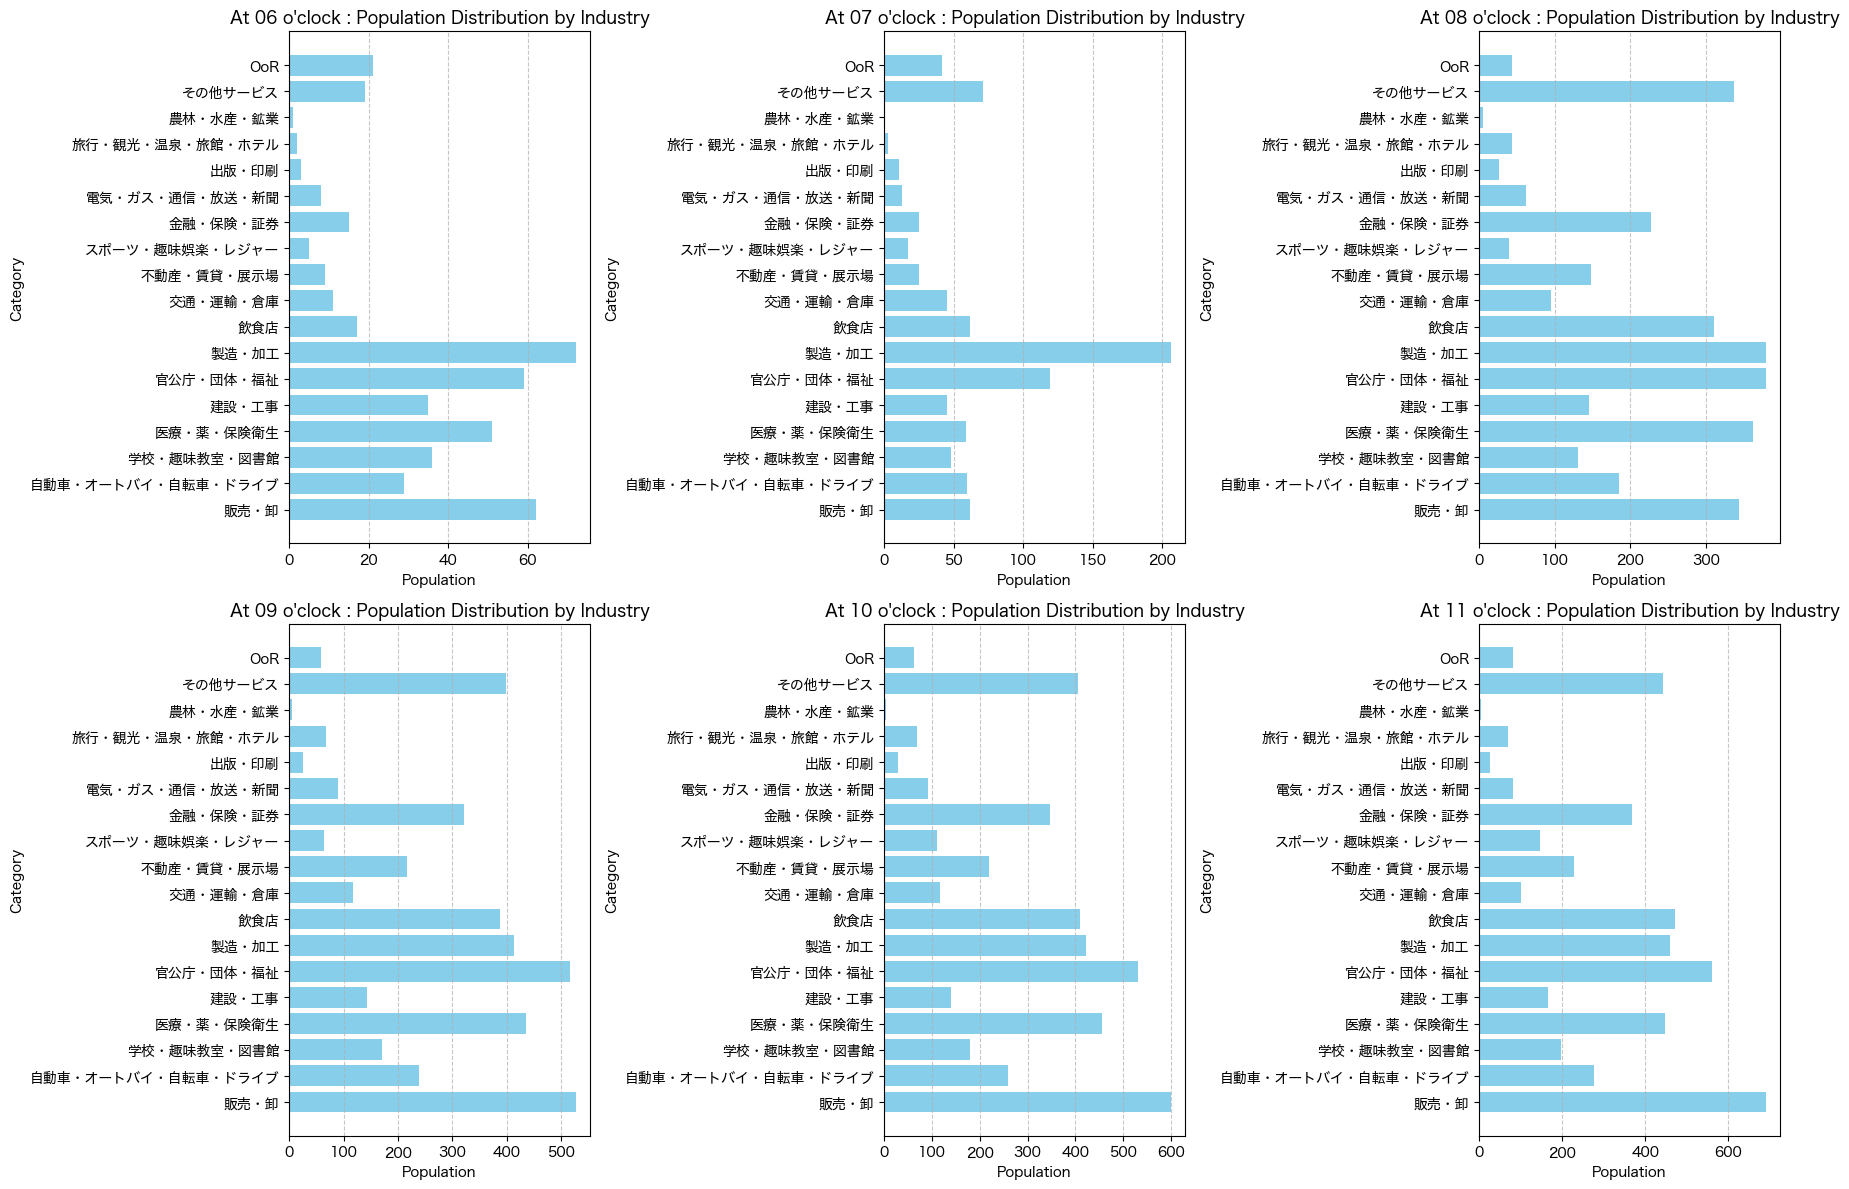

In [14]:
file_path = '/Users/y-osamu/study/poi_sim/data/processed/true_data/06_fin.json' # 調布市の正解データ
file_path_base = '/Users/y-osamu/study/poi_sim/data/processed/true_data/'


true_files = sorted(glob.glob(os.path.join(file_path_base,'*.json')))
true_files

# 2列3行のサブプロットを作成
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# グラフの位置を調整
axs = axs.flatten()

# 各ファイルについて処理
for i, file in enumerate(true_files):
    file_name = os.path.basename(file)[:2]  # Extracts the file name from the path
    
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    df = pd.DataFrame(list(data.items()), columns=["category", "population"])

    # メッシュ番号を抽出
    df["Mesh Number"] = df["category"].apply(lambda x: x.split("_")[0])
    df["category"] = df["category"].apply(lambda x: x.split("_")[1])
    df = df[~df["category"].isin(["Home", "Move"])]
    
    # サブプロットにデータを描画
    axs[i].barh(df["category"], df["population"], color="skyblue")
    axs[i].set_xlabel("Population")
    axs[i].set_ylabel("Category")
    axs[i].set_title(f"At {file_name} o'clock : Population Distribution by Industry")
    axs[i].grid(axis="x", linestyle="--", alpha=0.7)

# レイアウト調整
plt.tight_layout()
plt.show()

### 1-2. 各時点のメッシュとPoIの分布　アニメーション

In [15]:
# アニメーション描画する関数
def make_heatmap_animation(true_files):
    """
    毎回 新しい Figure / Animation を作って返す
    → 何回表示しても warning が出ない
    """

    fig, ax = plt.subplots(figsize=(22, 15))
    cbar_shown = False

    def update_heatmap(frame):
        nonlocal cbar_shown

        with open(true_files[frame], 'r', encoding='utf-8') as f:
            data = json.load(f)

        df = pd.DataFrame(list(data.items()), columns=["key", "value"])
        df["mesh"] = df["key"].str.split("_").str[0]
        df["category"] = df["key"].str.split("_").str[1]
        df = df[~df["category"].isin(["Home", "Move"])]
        df = df.pivot(index="category", columns="mesh", values="value").fillna(0)

        ax.clear()
        sns.heatmap(
            df,
            cmap="Blues",
            annot=True,
            fmt="d",
            cbar=not cbar_shown,
            ax=ax
        )

        if not cbar_shown:
            cbar_shown = True

        ax.set_xlabel("メッシュ")
        ax.set_ylabel("カテゴリー")
        ax.set_title(
            f"At {os.path.basename(true_files[frame])} : メッシュ × カテゴリー 人口分布"
        )
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # ★ frames は range が最強
    ani = FuncAnimation(
        fig,
        update_heatmap,
        frames=range(len(true_files)),
        repeat=False
    )

    # ★ Notebook 安定化のため必須
    plt.close(fig)

    return HTML(ani.to_jshtml())


In [17]:
make_heatmap_animation(true_files)

### 1-3. 予測データの分析

In [ ]:
# 阪上さん予測データ

file_path = '/Users/y-osamu/study/poi_sim/data/processed/true_data/06_fin.json' # 調布市の正解データ
file_path_base = '/Users/osamu/study/sakagami/result/output_meshid_poi/8'


true_files = sorted(glob.glob(os.path.join(file_path_base,'*.json')))

# 現在のフレーム（ファイル）のデータを読み込む
with open(true_files[0], 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(list(data.items()), columns=["key", "value"])
# keyごとに処理
result_dfs = {}
for key, values in zip(df["key"], df["value"]):
    aggregated = defaultdict(lambda: defaultdict(int))
    
    for entry in values:
        mesh, category = entry.split("_")
        aggregated[mesh][category] += 1
    
    # データフレームに変換
    rows = []
    for mesh, categories in aggregated.items():
        for category, count in categories.items():
            rows.append([mesh, category, count])
    
    result_dfs[key] = pd.DataFrame(rows, columns=["Mesh", "Category", "Count"])
    
for key, df in result_dfs.items():
    heatmap_data = df.pivot(index="Category", columns="Mesh", values="Count").fillna(0)

    # ヒートマップを描画
    plt.figure(figsize=(16,12))
    sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt=".0f")
    plt.title(f"wolrd {key} : mesh × PoI")
    plt.xlabel("Mesh")
    plt.ylabel("Category")
    plt.xticks(rotation=45)
    plt.show()

IndexError: list index out of range

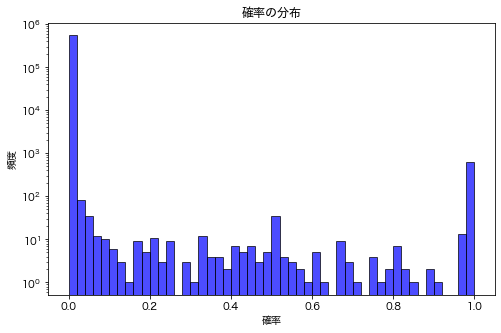

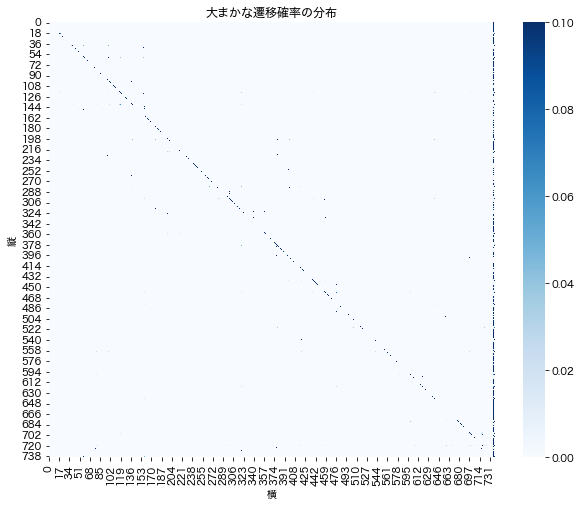

Non-zero ratio: 0.2935%


In [ ]:
# 遷移確率行列の　分析　

trans_prob_mat_dir = '/Users/osamu/study/sakagami/Sakagami_code/sakagami_processsing/pre/new'
mat_files = sorted(glob.glob(os.path.join(trans_prob_mat_dir,'*.npy')))

# 740×７４０ 547600　個の要素
    
# .npyファイルをロード
matrix = np.load(mat_files[0])

# すべての値を取得
values = matrix.flatten()

# ヒストグラムの描画
plt.figure(figsize=(8, 5))
plt.hist(values, bins=50, log=True, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel("確率")
plt.ylabel("頻度")
plt.title("確率の分布")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap="Blues", vmax=0.1)  
plt.title("大まかな遷移確率の分布")
plt.xlabel("横")
plt.ylabel("縦")
plt.show()

nonzero_ratio = np.count_nonzero(matrix) / matrix.size
print(f"Non-zero ratio: {nonzero_ratio:.4%}")




In [ ]:
file_path = '/Users/osamu/study/sakagami/Sakagami_code/sakagami_processsing/true_data/06_fin.json' # 調布市の正解データ
file_path_base = '/Users/osamu/study/sakagami/Sakagami_code/sakagami_processsing/true_data/'


true_files = sorted(glob.glob(os.path.join(file_path_base,'*.json')))

# 現在のフレーム（ファイル）のデータを読み込む
with open(true_files[0], 'r', encoding='utf-8') as f:
    data_6am = json.load(f)
    
# 現在のフレーム（ファイル）のデータを読み込む
with open(true_files[1], 'r', encoding='utf-8') as f:
    data_7am = json.load(f)
    
df_6am = pd.DataFrame(list(data_6am.items()), columns=["category", "population"])

# メッシュ番号を抽出
df_6am["Mesh Number"] = df_6am["category"].apply(lambda x: x.split("_")[0])
df_6am["category"] = df_6am["category"].apply(lambda x: x.split("_")[1])
df_6am

data_7am = pd.DataFrame(list(data_7am.items()), columns=["category", "population"])

# メッシュ番号を抽出
data_7am["Mesh Number"] = data_7am["category"].apply(lambda x: x.split("_")[0])
data_7am["category"] = data_7am["category"].apply(lambda x: x.split("_")[1])
data_7am

data_7am

,category,population,Mesh Number
0,販売・卸,0,53393462
1,自動車・オートバイ・自転車・ドライブ,0,53393462
2,学校・趣味教室・図書館,0,53393462
3,医療・薬・保険衛生,0,53393462
4,建設・工事,0,53393462
...,...,...,...
735,農林・水産・鉱業,1,11111111
736,その他サービス,58,11111111
737,Home,967,11111111
738,OoR,20,11111111


## 阪上さんの遷移確率実行結果を再現
    
- 東京都調布市の大カテゴリーの遷移確率
    - 対象時間:8時から9時
    - 対象期間:2019.02.01 - 2019.04.15
    - 分類方法:山田の分類方法
    
    

In [ ]:
# original data のデータの解析
df = pd.read_csv("../data/20190201.csv")
df = df.drop(columns=["Unnamed: 0"])
list(df.columns)

['citycode',
 'dailyid',
 'home_citycode',
 'judge',
 'lat',
 'lon',
 'mesh100mid',
 'poi',
 'prefcode',
 'time',
 'workplace_citycode']

In [ ]:
df = pd.read_csv("../data/201902_week1.csv")
df = df.drop(columns=["Unnamed: 0"])
df_home = pd.read_csv("../data/201902_week1_home.csv")
df_home = df_home.drop(columns=["Unnamed: 0"])
df_output = pd.read_csv("../data/201902_week1_output.csv")
df_output = df_output.drop(columns=["Unnamed: 0"])


In [ ]:
files = glob.glob("../data/201902*output*")
files

['../data/201902_week1_output.csv',
 '../data/201902_week4_output.csv',
 '../data/201902_week3_output.csv',
 '../data/201902_week4_pre_output.csv',
 '../data/201902_week4_pre_output_06_02.csv',
 '../data/201902_week2_output.csv']